In [1]:
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from modules.cae import CAE
from modules.train_cae import train_cae
from modules.clustering import extract_latents, run_clustering, evaluate_clustering
from modules.classifier import MLPClassifier, train_classifier
from modules.utils import stratified_split, plot_reconstructions, plot_clusters
import numpy as np
import os

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets (assuming subfolders per class, else use a custom Dataset)
dibas_ds = datasets.ImageFolder('data/augmented/dibas', transform=transform)
clinical_pb_ds = datasets.ImageFolder('data/augmented/clinical-pb', transform=transform)

# Helper to split indices
def split_indices(n, split=0.8, seed=42):
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    split_point = int(n * split)
    return idxs[:split_point], idxs[split_point:]

# Split dibas: 80% train, 20% val
dibas_train_idx, dibas_val_idx = split_indices(len(dibas_ds), split=0.8)
dibas_train = Subset(dibas_ds, dibas_train_idx)
dibas_val = Subset(dibas_ds, dibas_val_idx)

# Split clinical-pb: 80% train, 20% test
clinical_train_idx, clinical_test_idx = split_indices(len(clinical_pb_ds), split=0.8)
clinical_train = Subset(clinical_pb_ds, clinical_train_idx)
clinical_test = Subset(clinical_pb_ds, clinical_test_idx)

# Combine as requested
train_dataset = ConcatDataset([dibas_train, clinical_train])
val_dataset = dibas_val
test_dataset = clinical_test

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading checkpoint: checkpoints/cae_epoch_19.pt


Epoch 20/100 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: train_loss=0.0235, val_loss=0.0217


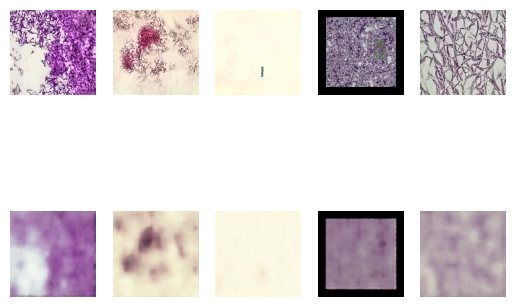

Epoch 21: train_loss=0.0237, val_loss=0.0215


Epoch 22: train_loss=0.0234, val_loss=0.0216


Epoch 23: train_loss=0.0232, val_loss=0.0215


Epoch 24: train_loss=0.0232, val_loss=0.0214


Epoch 25: train_loss=0.0231, val_loss=0.0214


Epoch 26: train_loss=0.0230, val_loss=0.0222


Epoch 27: train_loss=0.0231, val_loss=0.0219


Epoch 28: train_loss=0.0228, val_loss=0.0214


Epoch 29: train_loss=0.0224, val_loss=0.0214
Early stopping.


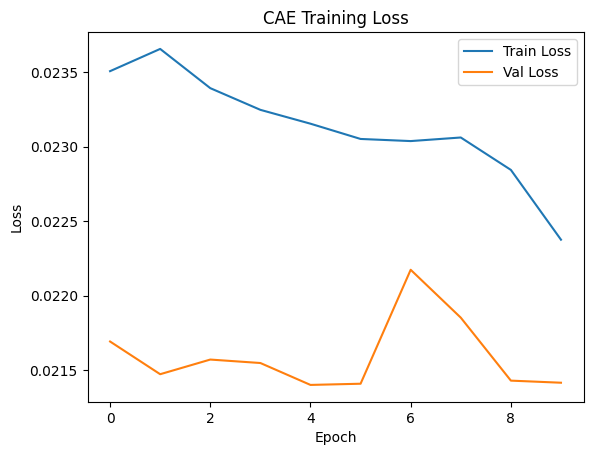

In [7]:
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cae = CAE(latent_dim=64, dropout=0.2).to(device)
optimizer = torch.optim.Adam(cae.parameters(), lr=3e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

checkpoint_files = sorted(glob.glob("checkpoints/cae_epoch_*.pt"))
if checkpoint_files:
    latest_ckpt = checkpoint_files[-1]
    print(f"Loading checkpoint: {latest_ckpt}")
    checkpoint = torch.load(latest_ckpt, map_location=device)
    cae.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
else:
    print("No checkpoint found, starting from scratch.")
    start_epoch = 0

stats = train_cae(
    cae, train_loader, val_loader, optimizer, scheduler, device,
    n_epochs=100, early_stop=5, visualize_fn=plot_reconstructions,
    start_epoch=start_epoch,
)

In [12]:
latents = extract_latents(cae, train_loader, device)
labels, clusterer = run_clustering(latents, method="kmeans", n_clusters=2)
metrics = evaluate_clustering(latents, labels)
print(metrics)

/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'silhouette': np.float32(0.47172928), 'davies_bouldin': np.float64(1.455839960168402), 'calinski_harabasz': np.float32(1933.2178)}


/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


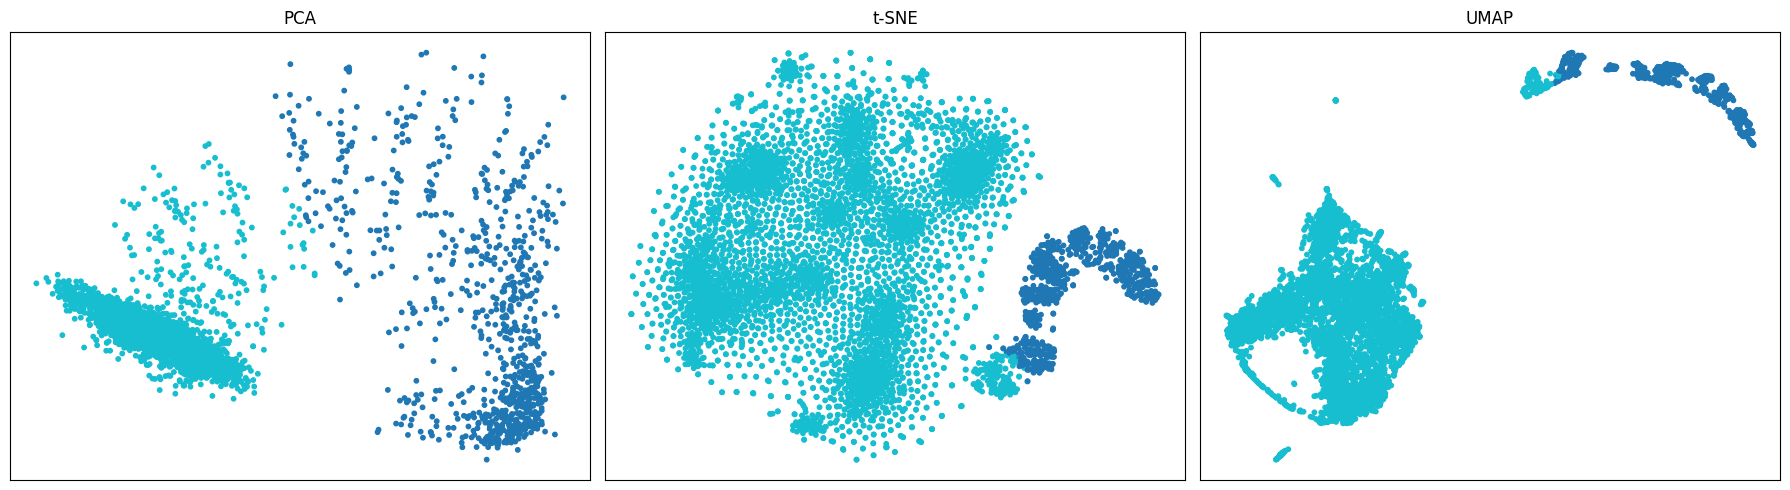

In [13]:
# Compare t-SNE, UMAP, and PCA for latent space visualization

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Reduce to 2D with each method
latents_pca = PCA(n_components=2, random_state=42).fit_transform(latents)
latents_tsne = TSNE(n_components=2, random_state=42).fit_transform(latents)
latents_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(latents)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, data, title in zip(
    axs,
    [latents_pca, latents_tsne, latents_umap],
    ["PCA", "t-SNE", "UMAP"]
):
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

/tmp/ipykernel_100360/2365675558.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap)


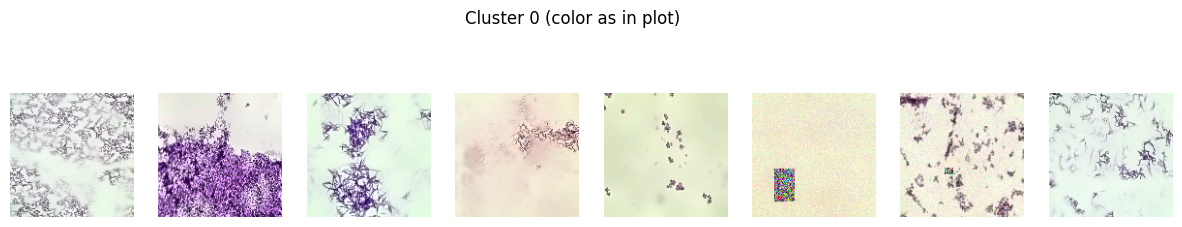

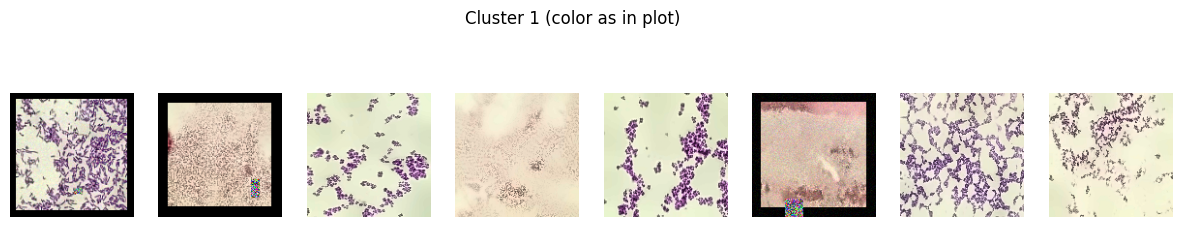

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def show_cluster_images_with_color(dataset, labels, cluster_id, n_images=8, cmap='tab10'):
    idxs = np.where(labels == cluster_id)[0]
    cmap = mpl.cm.get_cmap(cmap)
    color = cmap(cluster_id)
    fig, axs = plt.subplots(1, min(n_images, len(idxs)), figsize=(15, 3))
    for i, ax in enumerate(axs):
        img, _ = dataset[idxs[i]]
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img.squeeze(), cmap='gray' if img.shape[-1] == 1 else None)
        ax.axis('off')
        # Add a colored border to match the cluster color
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(4)
    plt.suptitle(f"Cluster {cluster_id} (color as in plot)")
    plt.show()

# Show images for each cluster/color
for cluster_id in np.unique(labels):
    show_cluster_images_with_color(train_dataset, labels, cluster_id, n_images=8)

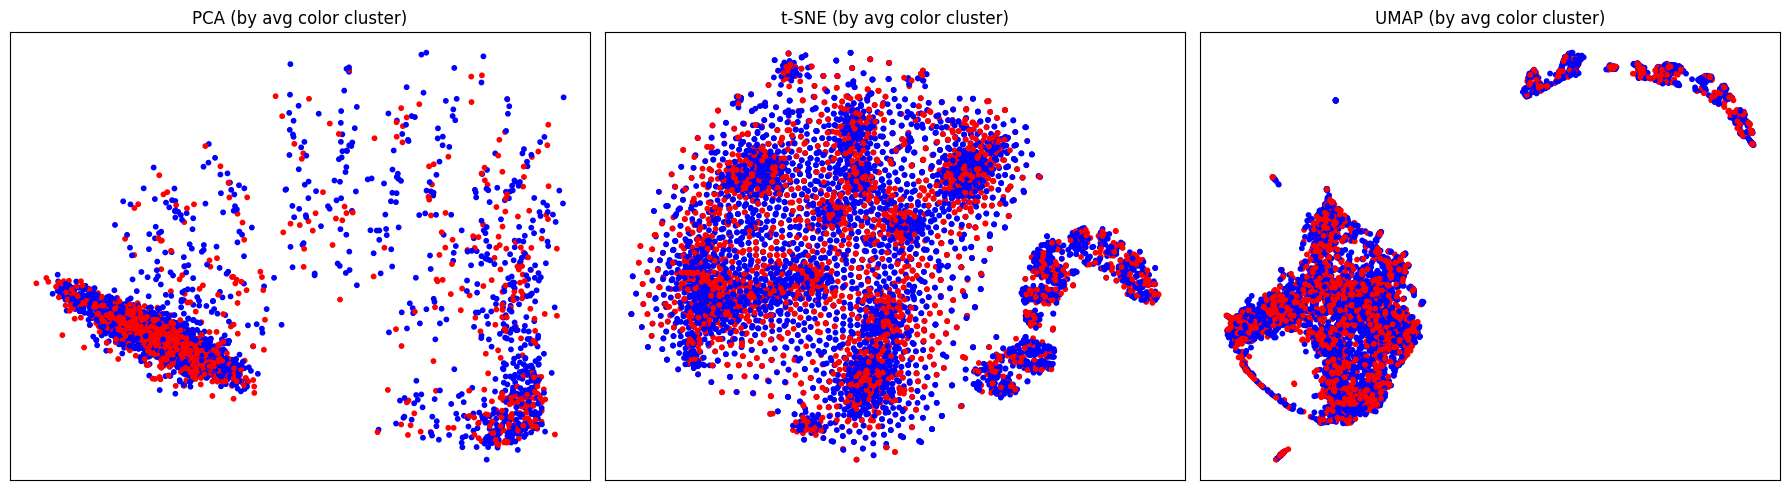

In [15]:
import numpy as np
from sklearn.cluster import KMeans

def get_avg_color(img):
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()
    return img.reshape(-1, 3).mean(axis=0)

# Compute average color for each image
avg_colors = np.array([get_avg_color(train_dataset[i][0]) for i in range(len(train_dataset))])

# Cluster based on average color (2 clusters: Gram-positive, Gram-negative)
color_labels = KMeans(n_clusters=2, random_state=42).fit_predict(avg_colors)

# Visualize in latent space, colored by color-based clusters
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, data, title in zip(
    axs,
    [latents_pca, latents_tsne, latents_umap],
    ["PCA", "t-SNE", "UMAP"]
):
    scatter = ax.scatter(data[:, 0], data[:, 1], c=color_labels, cmap='bwr', s=10)
    ax.set_title(f"{title} (by avg color cluster)")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


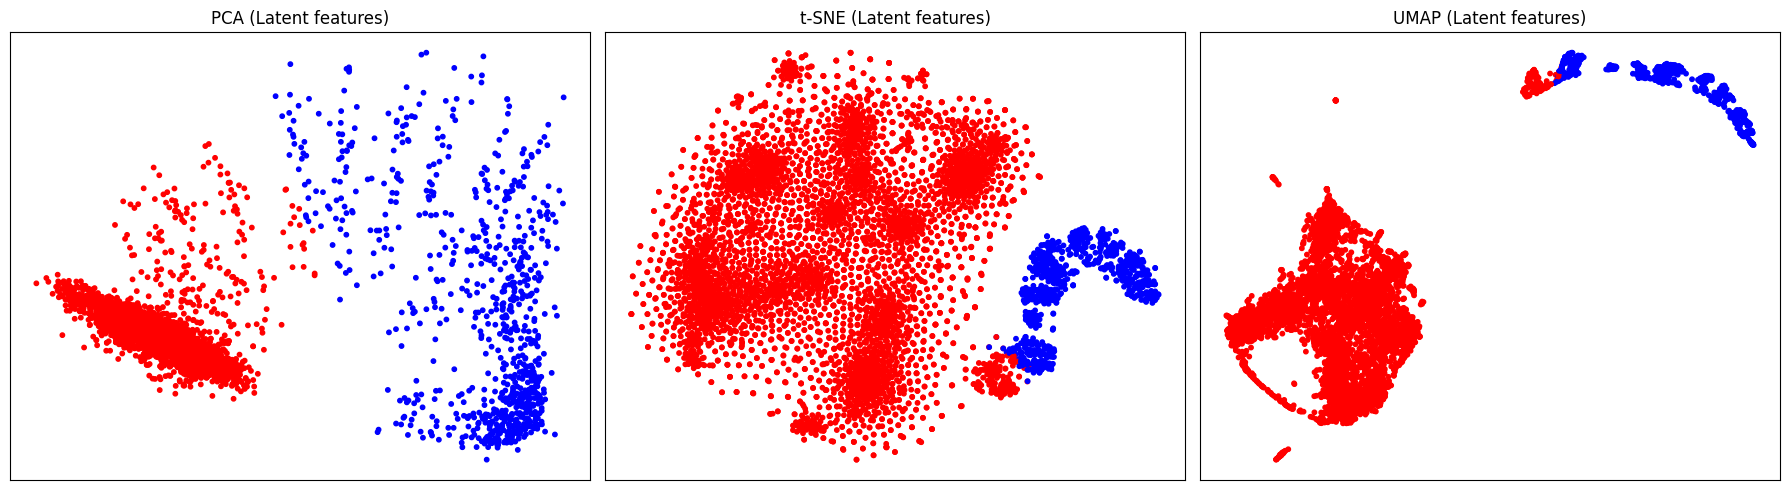

/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

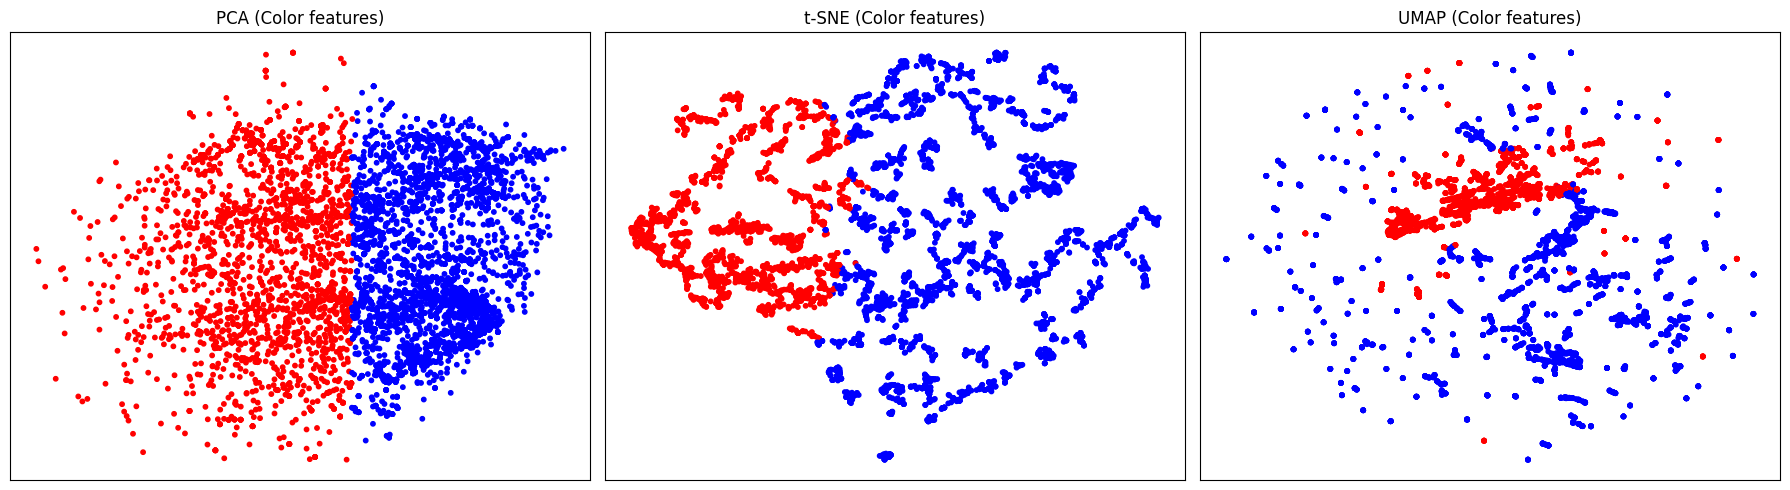

/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jeyb/Desktop/gramAI/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


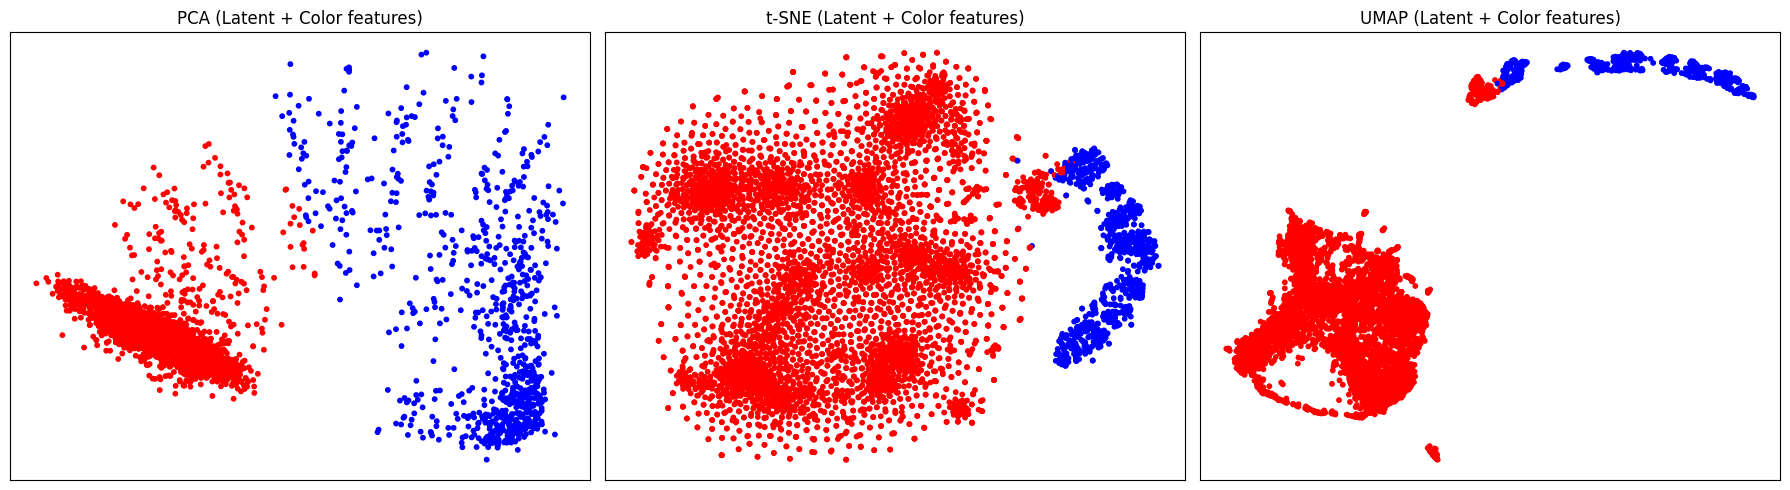

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Prepare feature sets
feature_sets = [
    (latents, "Latent features"),
    (avg_colors, "Color features"),
    (combined_features, "Latent + Color features"),
]

# Prepare clustering labels for each feature set
labels_sets = [
    KMeans(n_clusters=2, random_state=42).fit_predict(latents),
    KMeans(n_clusters=2, random_state=42).fit_predict(avg_colors),
    KMeans(n_clusters=2, random_state=42).fit_predict(combined_features),
]

# Visualization
for (features, title), labels in zip(feature_sets, labels_sets):
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(features)
    tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(features)
    umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(features)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for ax, data, method in zip(
        axs,
        [pca_2d, tsne_2d, umap_2d],
        ["PCA", "t-SNE", "UMAP"]
    ):
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='bwr', s=10)
        ax.set_title(f"{method} ({title})")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [17]:
import numpy as np

# latents: (n_samples, latent_dim)
# avg_colors: (n_samples, 3) from previous example

combined_features = np.concatenate([latents, avg_colors], axis=1)

# Now cluster on combined_features
from sklearn.cluster import KMeans
# labels_combined = KMeans(n_clusters=2, random_state=42).fit_predict(combined_features)

# Visualize as before (using t-SNE/UMAP on combined_features if desired)

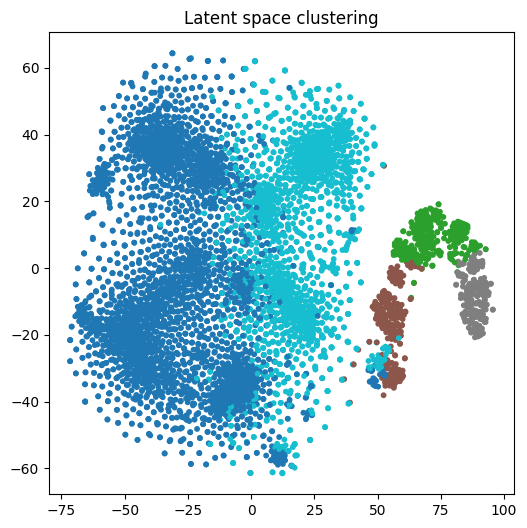

In [9]:
from sklearn.manifold import TSNE
latents_2d = TSNE(n_components=2, random_state=42).fit_transform(latents)
plot_clusters(latents_2d, labels)

In [ ]:
mlp = MLPClassifier(input_dim=latents.shape[1], num_classes=len(set(labels))).to(device)